In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
import andreap
from scipy.interpolate import interp1d

import importlib.util
import sys

In [2]:
test_index = 0
validation_set = False
# skips comparison with Andrea's code
fast = False

In [3]:
''' This messiness is necessary to import scripts which are not installed and
which are not located in the cwd.'''

spec = importlib.util.spec_from_file_location(
    "camb_interface", "../../cassL/camb_interface.py")
ci = importlib.util.module_from_spec(spec)
sys.modules["camb_interface"] = ci
spec.loader.exec_module(ci)

spec = importlib.util.spec_from_file_location(
    "generate_training_data", "../../cassL/generate_training_data.py")
gtd = importlib.util.module_from_spec(spec)
sys.modules["generate_training_data"] = gtd
spec.loader.exec_module(gtd)

In [4]:
hc = np.load("hc_G3_redo.npy",
    allow_pickle=True)
samples = np.load("samples_G3_redo.npy",
    allow_pickle=True)

if False:
    hc = np.load("hc_backup_i4999_massive_pred_revised.npy",
        allow_pickle=True)
    samples = np.load("samples_backup_i4999_massive_pred_revised.npy",
        allow_pickle=True)

if validation_set:
    hc = np.load("hc_test_G3.npy",
        allow_pickle=True)
    samples = np.load("samples_test_G3.npy",
        allow_pickle=True)
    
standard_k = np.load("standard_k.npy", allow_pickle=True)

In [5]:
test_cosmology = hc[test_index]
test_pspec = samples[test_index]

In [6]:
ombh2 = test_cosmology[0]
omch2 = test_cosmology[1]
ns = test_cosmology[2]
sigma12 = test_cosmology[3]
As = test_cosmology[4]
omnuh2 = test_cosmology[5]

In [7]:
full_cosm = gtd.build_cosmology(ombh2, omch2, ns, sigma12, As, omnuh2)

In [8]:
mnu = full_cosm['mnu']

In [23]:
# Comprehensive checking function
def get_sigma12_interpolator(ombh2, omch2, ns, mnu, h, As):
    Pk = andreap.get_PK(ombh2, omch2, ns, mnu, h * 100, As, w_mzero=True)
    
    z = np.linspace(0., 9., 500)
    sig12 = np.zeros(500)
    for i in range(500):
        sig12[i] = andreap.get_s12(Pk['mzero'], z[i])
    
    return interp1d(sig12, z, kind='cubic')
    
def validate_results(interpolator, sigma12, best_z):
    interpolator_best_z = None
    try:
        interpolator_best_z = interpolator(sigma12)
    except ValueError:
        print("The desired sigma12 is not attainable with this interpolator!")
        return
    
    print(best_z is None, interpolator_best_z is None)
    
    print("% discrepancy between results for best redshift:",
          (best_z - interpolator_best_z) / interpolator_best_z * 100)


MEMNeC:
ombh2 0.023080185000000003
omch2 0.11757400000000001
n_s 0.946505
A_s 2.8729609750468113e-09
OmK 0.0
OmL 0.681415906
h 0.67
w0 -1.0
wa 0.00
sigma12 0.9719208001518633
omnuh2 0
mnu 0.0

Original cosmology:
ombh2 0.023080185000000003
omch2 0.109367
n_s 0.946505
A_s 2.8729609750468113e-09
OmK 0.0
OmL 0.681415906
h 0.67
w0 -1.0
wa 0.00
sigma12 0.9719208001518633
omnuh2 0.008207
mnu 0.763278082362583


Maximum s12: 0.933928392486508


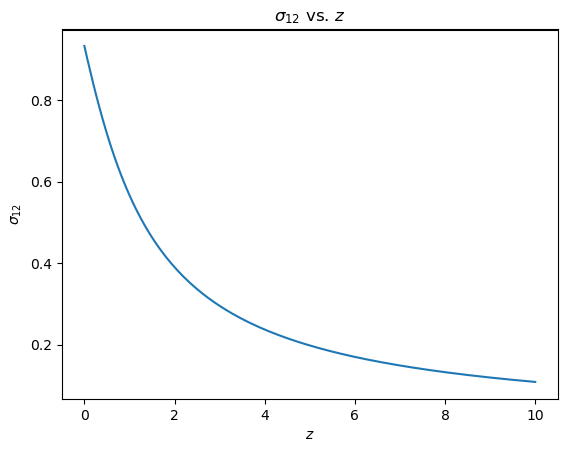

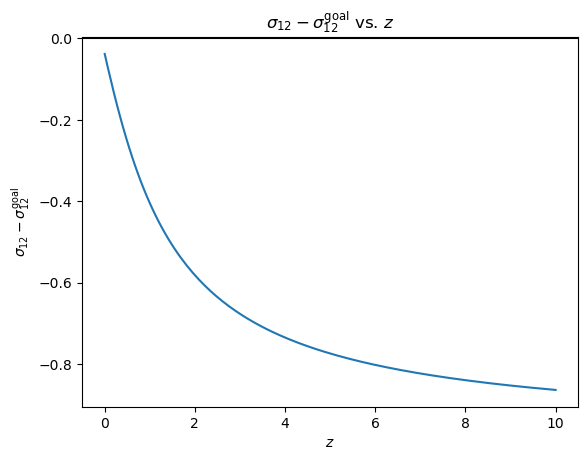

Discrepancy between maximal achievable sigma12 and target -0.03799240766535528
Target sigma12: 0.9719208001518633

MEMNeC:
ombh2 0.023080185000000003
omch2 0.11757400000000001
n_s 0.946505
A_s 2.8729609750468113e-09
OmK 0.0
OmL 0.681415906
h 0.5700000000000001
w0 -1.0
wa 0.00
sigma12 0.9719208001518633
omnuh2 0
mnu 0.0

Original cosmology:
ombh2 0.023080185000000003
omch2 0.109367
n_s 0.946505
A_s 2.8729609750468113e-09
OmK 0.0
OmL 0.681415906
h 0.5700000000000001
w0 -1.0
wa 0.00
sigma12 0.9719208001518633
omnuh2 0.008207
mnu 0.763278082362583


Maximum s12: 1.0040115361127562


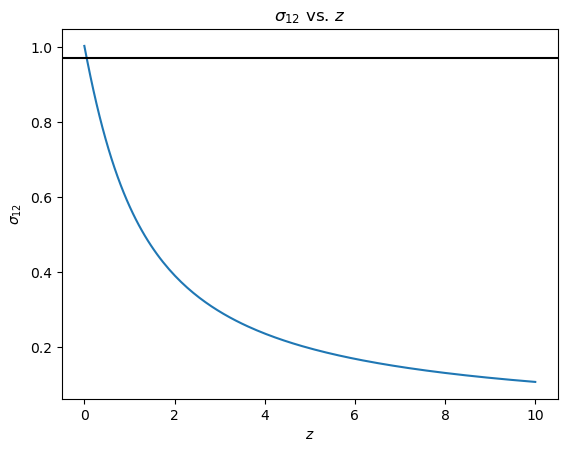

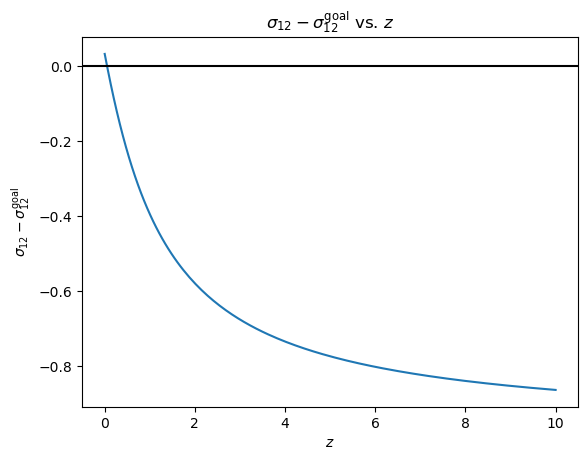

Discrepancy between maximal achievable sigma12 and target 0.03209073596089285
Target sigma12: 0.9719208001518633
recommended redshift 0.05165493613300337
We had to move h to 0.57
This is our approximation 0.971921597558254


In [10]:
g_pspec, g_sigma12, g_z = gtd.evaluate_cell(full_cosm, standard_k, debug=True)
print("This is our approximation", g_sigma12)

In [24]:
s12i_hi_h = get_sigma12_interpolator(
    ombh2, omch2, ns, mnu, .57, As)
    
validate_results(s12i_hi_h, sigma12, g_z)
print()
validate_results(s12i_hi_h, g_sigma12, g_z)

0.008207
1
massive-neutrino sigma12 [0.80262619]
massless-neutrino sigma12 [1.00397832]
False False
% discrepancy between results for best redshift: 0.09992739155824489

False False
% discrepancy between results for best redshift: 0.10246413253955339


In [20]:
stop

NameError: name 'stop' is not defined

In [ ]:
import copy as cp
MEMNeC = cp.deepcopy(full_cosm)
MEMNeC['omch2'] += MEMNeC['omnuh2']
MEMNeC = ci.specify_neutrino_mass(MEMNeC, 0, 0)
gtd.print_cosmology(MEMNeC)
print()
gtd.print_cosmology(full_cosm)

In [ ]:
kci_t, zci_t, pci_t, sci_t = ci.evaluate_cosmology(MEMNeC, redshifts=[g_z], k_points=300)
kci, zci, pci, sci = ci.evaluate_cosmology(full_cosm, redshifts=[g_z], k_points=300)

In [ ]:
sci

In [ ]:
g_pspec_t, g_sigma12_t, g_z_t = gtd.evaluate_cell(MEMNeC, standard_k)
print("This is our approximation", g_sigma12_t)

In [ ]:
if not fast:
    andreap.get_s12(Pk_hi_h['mzero'], 0)

In [ ]:
# I cannot figure out how to get AndreaP's function to work
#andreap.get_s12_fixedz(Pk_hi_h['mzero'])

In [ ]:
MEMNeC

In [ ]:
plt.plot(standard_k, (pci - samples[test_index]) / samples[test_index] * 100)
plt.xscale('log')
plt.title("Discrepancy between Saved Spectrum and Direct kzps Call")
plt.ylabel('Percent Error')
plt.xlabel('scale $k$ [1 / Mpc]')

In [ ]:
plt.plot(standard_k, (g_pspec - samples[test_index]) / samples[test_index] * 100)
plt.xscale('log')
plt.title("Discrepancy between Saved Spectrum and On-the-fly psz Call")
plt.ylabel('Percent Error')
plt.xlabel('scale $k$ [1 / Mpc]')

In [ ]:
plt.plot(standard_k, (pci - g_pspec) / pci * 100)
plt.xscale('log')
plt.title("Discrepancy between On-the-fly psz and kzps Calls")
plt.ylabel('Percent Error')
plt.xlabel('scale $k$ [1 / Mpc]')

This most recent plot is weak enough that we're happy. But why do we see differences in the previous plots? Is this a reproduceable discrepancy?

In [ ]:
resample, bestz = gtd.fill_hypercube(hc, standard_k, massive_neutrinos=True,
    cell_range=range(1))
resample = resample[0]

In [ ]:
plt.plot(standard_k,
    (resample - samples[test_index]) / samples[test_index] * 100)
plt.xscale('log')